#### Name : Janhavi Katre 
#### Roll No : 05

In [42]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [43]:
# Parameters
img_height, img_width, img_channel = 32,32,3
n_batch = 128
n_epoch = 100
latent_dim = 7

In [44]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
cifar10 = np.concatenate([x_train, x_test], axis=0)
cifar10 = cifar10.astype("float32") / 255

In [45]:
print(type(cifar10))

<class 'numpy.ndarray'>


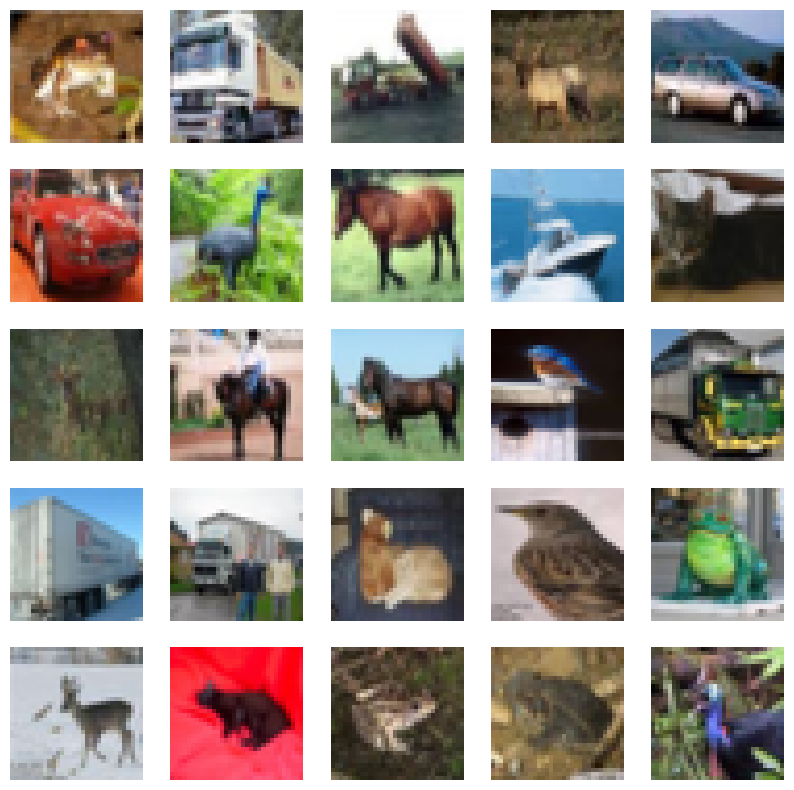

In [46]:
# Visualize CIFAR-10 data
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # Display a CIFAR-10 color image
    plt.imshow(cifar10[i])
    plt.axis("off")


#To define the VAE function, we should keep in mind different components of the encoder, reparameterization/sampling layer and decoder are defined separately and in sequence.

#The loss function is defined as the summation of reconstruction_loss plus the kl_loss as explained in the theory section.

In [47]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(8 * 8 * 64, activation="relu"),  # Adjusted dimensions
            Reshape((8, 8, 64)),  # Adjusted dimensions
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(3, 3, activation="sigmoid", padding="same"),  # 3 channels for RGB
        ])


        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [48]:
# Train the VAE

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(cifar10, epochs=n_epoch, batch_size=n_batch)


Epoch 1/100
469/469 [==============================] - 10s 11ms/step - loss: 692.3266 - reconstruction_loss: 678.8998 - kl_loss: 3.3827
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 672.2013 - reconstruction_loss: 668.0905 - kl_loss: 3.3535
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 669.3844 - reconstruction_loss: 666.6178 - kl_loss: 2.6389
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 668.8620 - reconstruction_loss: 666.1818 - kl_loss: 2.4373
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 668.3783 - reconstruction_loss: 665.9265 - kl_loss: 2.3648
Epoch 6/100
469/469 [==============================] - 5s 10ms/step - loss: 668.1830 - reconstruction_loss: 665.7753 - kl_loss: 2.3372
Epoch 7/100
469/469 [==============================] - 5s 11ms/step - loss: 668.3739 - reconstruction_loss: 665.7254 - kl_loss: 2.3276
Epoch 8/100
469/469 [==============================] -

# To generate new images similar to Fashion MNIST dataset, we only need to provide a pair of (μ, σ) values to the decoder.

In [49]:
print(vae)

1/1 [==============================] - 0s 20ms/step


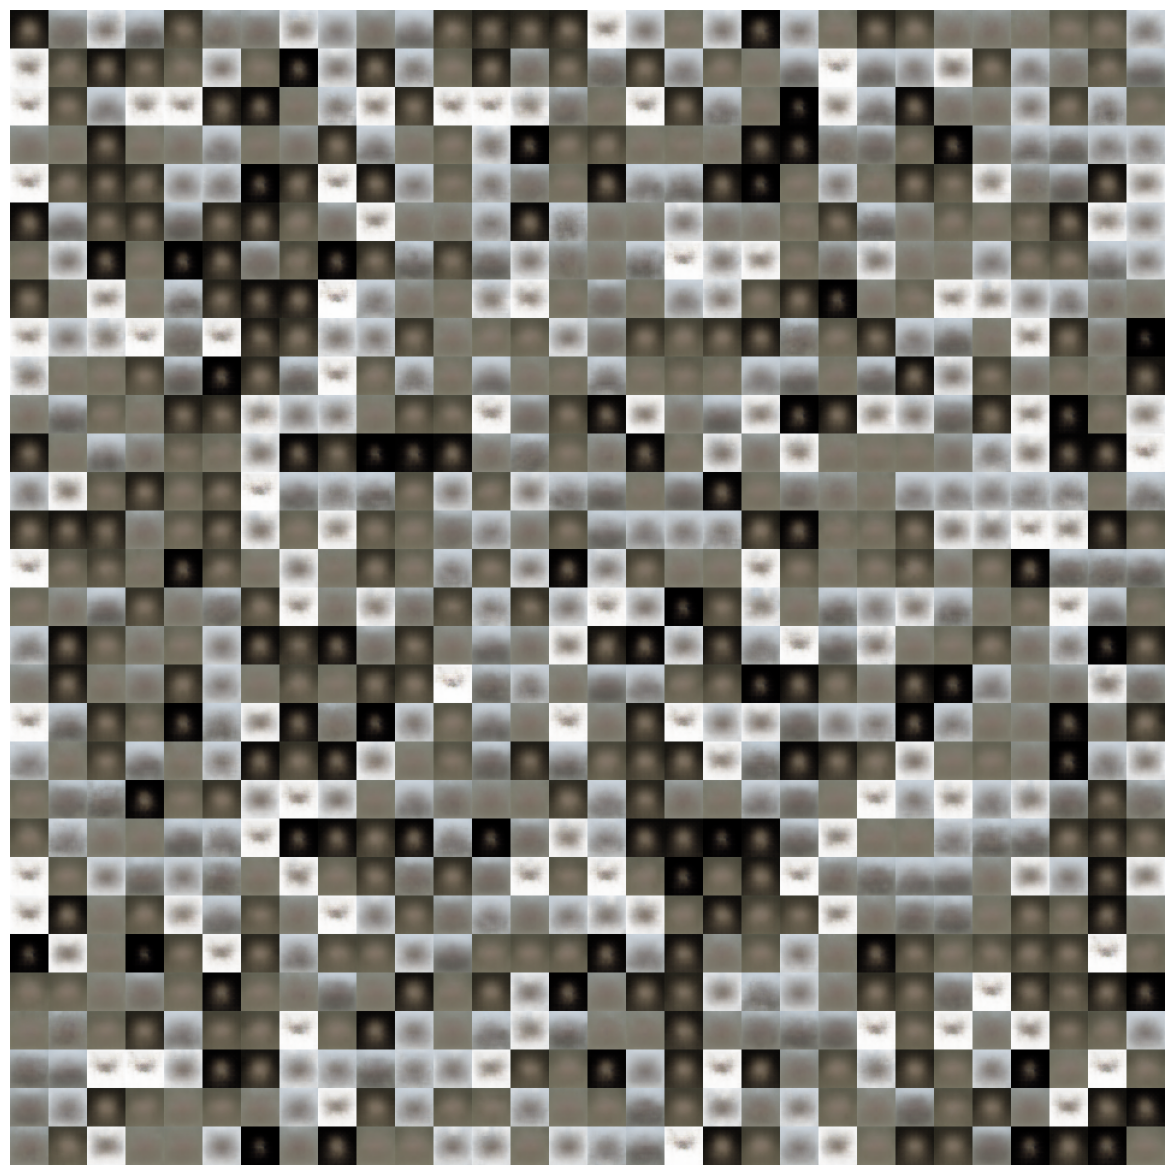

In [50]:
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 32  # Updated to match CIFAR-10 image height
    img_width = 32   # Updated to match CIFAR-10 image width

    # Create an empty figure to display the images
    figure = np.zeros((img_height * n, img_width * n, 3), dtype=np.uint8)  # 3 channels for RGB

    # Generate a grid of latent space values
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(size=(1, latent_dim)) * 2
            x_decoded = vae.decoder.predict(z_sample)  # Generate an image from the latent space

            # Convert the image to the correct data format (uint8) and add it to the figure
            x_decoded = (x_decoded * 255).astype(np.uint8)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_width : (j + 1) * img_width,
                :,
            ] = x_decoded[0]

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure)
    plt.axis('off')
    plt.show()

# Example usage
plot_latent_space(vae)
